importing necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

we read datas with using pandas library 

In [2]:
df= pd.read_csv('ARIMA_dataset_copy.csv')

we delete the rows with null values for cleaning the data

In [3]:
df1 = df.dropna()

In [4]:
df1=df1.copy()

we seperate the different part of the date with split function

In [5]:
df1['time']=df1['time'].str.split().str[0]

we show the head of our data frame with head() function

In [6]:
df1['time'].head()

0    2022-03-19
1    2022-03-19
2    2022-03-19
3    2022-03-19
4    2022-03-19
Name: time, dtype: object

we change the type of 'time' column to datetime type

In [7]:
df1['time']=pd.to_datetime(df1['time'])

we extract the day from date using code below and then transfer it to another column

In [8]:
df1['day']=df1['time'].dt.day


In [9]:
df1.head()

,time,lat,lon,dev_acc_d,day
0,2022-03-19,35.724380,51.386521,0.00000,19
1,2022-03-19,35.723492,51.385984,0.00000,19
2,2022-03-19,35.723234,51.386712,0.07172,19
3,2022-03-19,35.723138,51.387657,0.15773,19
4,2022-03-19,35.723082,51.388778,0.25916,19


we delete the extra columns

In [10]:
df1.drop(['lat','lon'] ,axis=1 )

,time,dev_acc_d,day
0,2022-03-19,0.00000,19
1,2022-03-19,0.00000,19
2,2022-03-19,0.07172,19
3,2022-03-19,0.15773,19
4,2022-03-19,0.25916,19
...,...,...,...
47086,2022-03-31,3428.64584,31
47087,2022-03-31,3428.64647,31
47088,2022-03-31,3428.64651,31
47089,2022-03-31,3428.65571,31


Through the following code, we first take the difference of each row with the previous row and put it in a new column.
Of course, because the wrong value is obtained for the first line, we put the value of the original row instead of the first line using the fillna() function.This makes the distance no longer cumulative and each line represents the distance traveled in the new time.

In [11]:
df1['distance']=df1.dev_acc_d.diff().fillna(df1.dev_acc_d)

Using the following command, we first group the rows by day, and then calculate the sum of each group. By doing this, we get the total distance traveled in each day.

In [12]:
df1.groupby(by='day')['distance'].sum()

day
19     25.18467
20    401.24335
21    401.24449
22    325.35858
23    202.00294
24    552.44416
26    297.04221
29    300.80688
30    922.06074
31      1.26930
Name: distance, dtype: float64

Days 25, 27, and 28 are missed. To determine a value for them, we take an average from the rest of the distances.

In [13]:
df1.groupby(by='day')['distance'].sum().mean()

342.865732

we put new datas into a new dataframe

In [14]:
lst1=['19','20','21','22','23','24','25','26','27','28' , '29','30' , '31']
lst2=[25.18467 ,401.24335, 401.24449 , 325.35858 , 202.00294 , 552.44416 , 342.865732,297.04221
     ,342.865732 , 342.865732 , 300.80688 , 922.06074 ,1.26930]
df2 = pd.DataFrame(list(zip(lst1, lst2)), columns =['day', 'distance'])
df2.tail()

,day,distance
8,27,342.865732
9,28,342.865732
10,29,300.806880
11,30,922.060740
12,31,1.269300


we need to check the stationary ,so we use the code below .if p value is less than 0.05 we dont need to 
calculate first difference of our data but if p value is more than 0.05 it indicates that we need to make our data stationary



In [15]:
print("Observations of Dickey-fuller test")
dftest = adfuller(df2['distance'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -5.709804e+00
p-value                        7.344220e-07
#lags used                     0.000000e+00
number of observations used    1.200000e+01
critical value (1%)           -4.137829e+00
critical value (5%)           -3.154972e+00
critical value (10%)          -2.714477e+00
dtype: float64


 we see the p value is more than 0.05 so we set d value to 1
 so we get first difference of datas


In [16]:
 distance2 = df2.distance.diff().fillna(df2.distance)


In [17]:
print("Observations of Dickey-fuller test")
dftest1 = adfuller(distance2,autolag='AIC')
dfoutput=pd.Series(dftest1[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest1[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                 -3.631315
p-value                         0.005190
#lags used                      1.000000
number of observations used    11.000000
critical value (1%)            -4.223238
critical value (5%)            -3.189369
critical value (10%)           -2.729839
dtype: float64


we conclude that d value should be 1 in order to have the p value less than 0.05


plotting the dataframe

<AxesSubplot:>

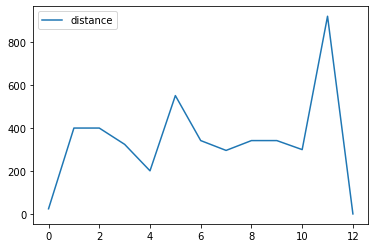

In [18]:
df2.plot()

The parameters of the ARIMA model are defined as follows:

p is the number of autoregressive terms,
d is the number of nonseasonal differences needed for stationarity, and
q is the number of lagged forecast errors in the prediction equation.

To determine the parameters of Arima
I gave different values to the parameter values to get approximate values
The closer and similar the graph obtained through Arima is to the graph of our data, the more appropriate those values are..

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


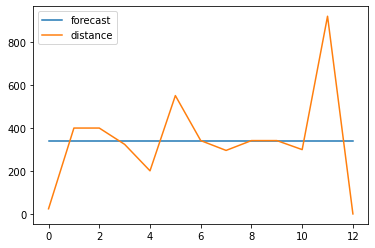

In [19]:
model = ARIMA(df2.distance, order = (0,0,0))
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.show()


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


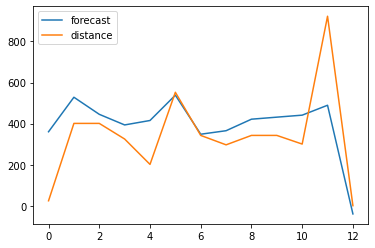

In [20]:
model = ARIMA(df2.distance, order = (0,0,1))
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.show()

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


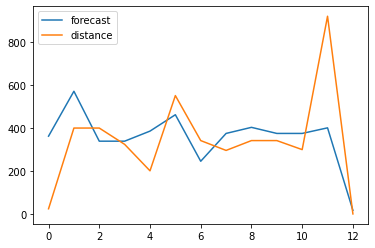

In [21]:
model = ARIMA(df2.distance, order = (1,0,0))
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.show()

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


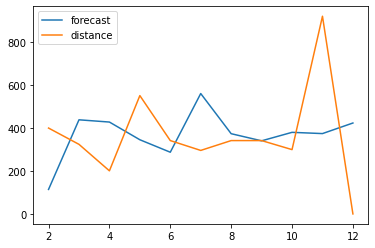

In [22]:
model = ARIMA(df2.distance, order = (1,1,0))
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.show()

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


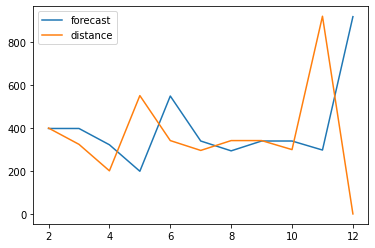

In [23]:
model = ARIMA(df2.distance, order = (0,1,0))
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.show()

In the last graph with the given values, the graph predicted by Arima is closer to the graph of our data.

now we can take these parameters from acf and pacf .
the number of lags that are out of the blue range is the value of p and q parameters except the first lag  because it is the correlation of the first data with itself.

in addition, acf give us the q value and pacf give us the p value


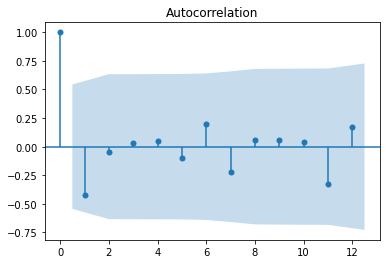

In [24]:
acf_plot = plot_acf(df2.distance )

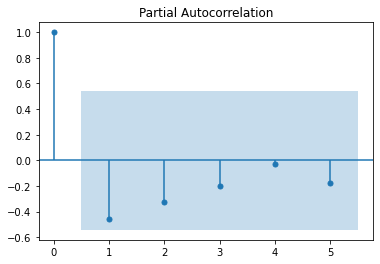

In [25]:
pacf_plot = plot_pacf(df2.distance , lags=5)

according to both acf and pacf value of p and q are 0.

we send the parameters to arima method to fit the model

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


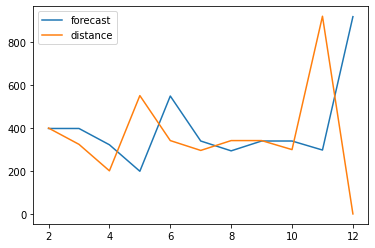

In [26]:
model = ARIMA(df2.distance, order = (0,1,0))
model_fit = model.fit(disp=0)
model_fit.plot_predict(dynamic=False)
plt.show()

 Forecasting five steps starting after the 13th observation in series


In [27]:
model_fit.predict()
print(model_fit.forecast(5))


(array([-0.7236475, -2.716595 , -4.7095425, -6.70249  , -8.6954375]), array([361.57775697, 511.34816776, 626.27104596, 723.15551395,
       808.51244374]), array([[ -709.40302878,   707.95573378],
       [-1004.94058738,   999.50739738],
       [-1232.17823715,  1222.75915215],
       [-1424.06125256,  1410.65627256],
       [-1593.35070829,  1575.95983329]]))


we see that arima predict five distances in future as 361.5777,511.3481 , 626.2710 , ....

The “AR” in ARIMA stands for autoregression, indicating that the model uses the dependent relationship between current data and its past values. In other words, it shows that the data is regressed on its past values.i proved from pacf that p parameter is better to be 0 . p=0

The “I” stands for integrated, which means that the data is stationary. Stationary data refers to time-series data that’s been made “stationary” by subtracting the observations from the previous values. i proved that our data only needs first order differencing to become stationary. d=1

The “MA” stands for moving average model, indicating that the forecast or outcome of the model depends linearly on the past values. Also, it means that the errors in forecasting are linear functions of past errors. i proved from acf that q value should be 0.